### Libraries

In [1]:
# !conda install statsmodels
# !pip install statsmodels
# !pip install pmdarima

In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

from sklearn.linear_model import LinearRegression

from statsmodels.api import OLS, add_constant, qqplot
from statsmodels.tsa.ar_model import AutoReg, ar_select_order
from statsmodels.graphics.tsaplots import plot_pacf, plot_acf
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.arima.model import ARIMA

from pmdarima.arima import auto_arima

from sklearn.metrics import mean_squared_error

# Set figure size to (14,6)
plt.rcParams['figure.figsize'] = (14,6)
plt.rcParams['font.size'] = '14'

# ignore warnings
import warnings
warnings.filterwarnings('ignore')

In [3]:
#Ho - null hypothesis: series is non stationary
#H1 - alternative hypothesis: series is stationary
def print_adf(data):
    
    """ Prints the results of the augmented Dickey Fuller Test"""
    
    adf_stats, p, used_lag, n_obs, levels, information_criterion = adfuller(data)
    
    print(f"""adf_stats: {adf_stats}
            p: {p} 
            used lag: {used_lag} 
            number of observations: {n_obs}
            CI 99%: {levels['1%']}
            CI 95%: {levels['5%']}
            CI 90%: {levels['10%']}
            information criterion (AIC): {information_criterion}
            """)
    

#Ho - null hypothesis: series is non stationary
#H1 - alternative hypothesis: series is stationary
def adfuller_test2(series): #Alternative way
    result=adfuller(series)
    labels = ['ADF Test Statistic','p-value','#Lags Used','Number of Observations Used']
    for value,label in zip(result,labels):
        print(label+' : '+str(value) )
    if result[1] <= 0.05:
        print("strong evidence against the null hypothesis(Ho), reject the null hypothesis. Data is stationary")
    else:
        print("weak evidence against null hypothesis, indicating data is non-stationary")

        
#adfuller_test(df_train['remainder'])

In [4]:
def plot_graph(df, title='Daily temperature in 1C', ylim=False):
    df.plot()
    plt.title(title)
    plt.ylabel('Temperature')
    if ylim:
        plt.ylim(ymin=0)
    plt.show()

### Load Data (Remainder! not the absolute number)

In [5]:
df_train = pd.read_csv('TG_remainder.csv',
                        parse_dates=True, 
                        index_col=0)
print(df_train.head(1),df_train.tail(1))

            remainder
DATE                 
1876-01-01   3.074636             remainder
DATE                 
2021-10-31   3.038431


### EXTRA: Augmented Dickey-Fuller Test. Check the remainder is stationary with . (By eye it looks like very stationary, just for exercise)

In [6]:
print_adf(df_train['remainder']) #def function is in libraries
#We define as 5%. So P is less than 0.05, also first value is smallr than CI 95%
#These mean, its sitationary

adf_stats: -23.80010074754268
            p: 0.0 
            used lag: 58 
            number of observations: 53206
            CI 99%: -3.4304729112415666
            CI 95%: -2.8615943243166493
            CI 90%: -2.5667989150245236
            information criterion (AIC): 239892.40175282795
            


### Calculate and add lag feature

##### Add lag1 by shift

In [7]:
df_train['lag_1'] = df_train['remainder'].shift(1)
df_train.head(3)

,remainder,lag_1
DATE,,
1876-01-01,3.074636,NaN
1876-01-02,3.374603,3.074636
1876-01-03,1.174570,3.374603


##### drop the first raw which has NaN, lag1

In [8]:
df_train.dropna(inplace=True)
df_train.head(3)

,remainder,lag_1
DATE,,
1876-01-02,3.374603,3.074636
1876-01-03,1.174570,3.374603
1876-01-04,-4.925462,1.174570


##### EXTRA: Add more lags (For manual way, check by eye. To automize the lag picking process, can be autocorrlation functions)

In [9]:
df_train_lagy=df_train
for i in range(2,11):
    name=f'lag_{i}'
    df_train_lagy[name] = df_train_lagy['remainder'].shift(i)
    df_train_lagy.dropna(inplace=True)
df_train_lagy.head(3)

,remainder,lag_1,lag_2,lag_3,lag_4,lag_5,lag_6,lag_7,lag_8,lag_9,lag_10
DATE,,,,,,,,,,,
1876-02-25,2.821913,4.821946,8.321979,10.022011,3.822044,5.122077,8.022110,6.522143,5.522175,5.322208,3.322241
1876-02-26,3.921880,2.821913,4.821946,8.321979,10.022011,3.822044,5.122077,8.022110,6.522143,5.522175,5.322208
1876-02-27,7.121848,3.921880,2.821913,4.821946,8.321979,10.022011,3.822044,5.122077,8.022110,6.522143,5.522175


##### EXTRA: inspect correlations manually

In [10]:
df_train.corr().head(1)
#If it was warm yesterday, it is more likely to be warm today
# If there were a lot of passengers last month we expect a lot of passengers this month

,remainder,lag_1,lag_2,lag_3,lag_4,lag_5,lag_6,lag_7,lag_8,lag_9,lag_10
remainder,1.0,0.803752,0.598843,0.462529,0.36953,0.300665,0.24612,0.202992,0.169052,0.139514,0.113779


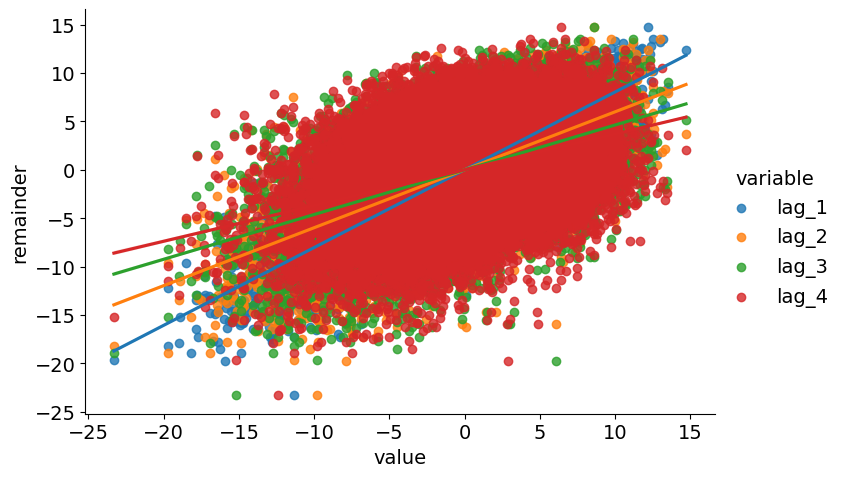

In [11]:
df_melted = df_train.melt(id_vars=['remainder'],value_vars=['lag_1','lag_2','lag_3','lag_4'])
sns.lmplot(x='value', y='remainder', data=df_melted, hue='variable', aspect=12/8)

#### Inspect correlations automatically! (first look before autocorrelations)

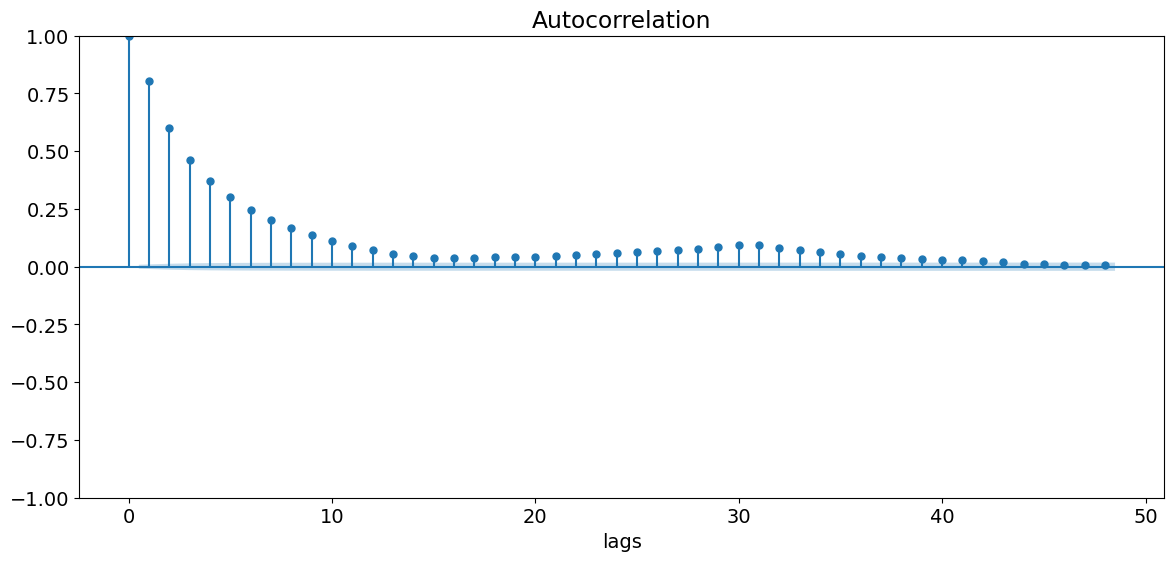

In [12]:
#Autocorrelation
plot_acf(df_train['remainder'])
plt.xlabel('lags')
plt.show()

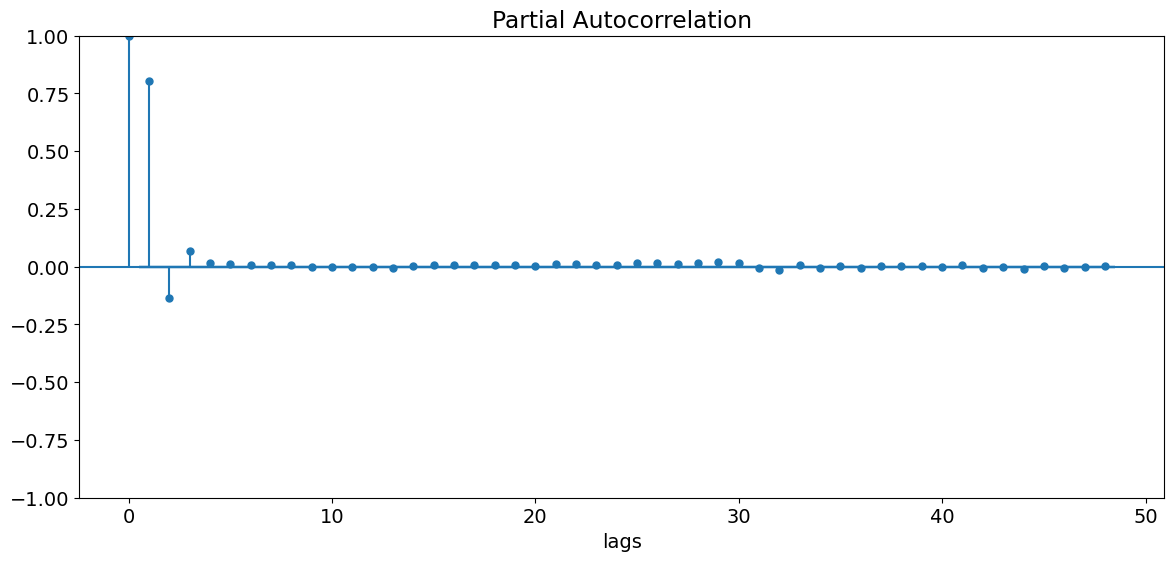

In [13]:
#Partial-Autocorrelation 
plot_pacf(df_train['remainder'])
plt.xlabel('lags')
plt.show()

AR process: If the ACF-Plot is showing a drop after a certain lag, and the PACF-Plot shows an exponential and slow decay, we conclude that the data is best modelled by an MA(q) process. q is given by the last meaningful lag in the ACF-Plot.

MA process: If both the ACF-Plot and the PACF-Plot are showing an exponential and slow decay, we conclude that the data is best modelled by an ARIMA(p,d,q) process. p and q cannot be inferred from the plots. Usually you would use an iterrative approach and try different combinations to find the best model. (eg. https://alkaline-ml.com/pmdarima/modules/generated/pmdarima.arima.auto_arima.html)

 Here data points start from zero and one should pick 'p_max' value from AR and 'q_max from MA for ARIMA.
 Here not so visible, but there is shadowed area. Choose data point (i) which is the last one before it goes the shattered area. If it is more complicated, choose latest datapoint which is out our went out from the area  
 Here autocorrelation gives correlation between train and lags. There is a constant correlation between all lags. Partial autocorrelation take only the lag t_i
 These functions work from the slope m of the linear regression, which is drawn one section before at manually correlation 

 So lets p_max(AR)--> 10 (complicated to choose. One can choose more but takes a long!)
         q_max(MR)--> 3

### MODELing on train data

How do I determine which model to choose?

    1.test stationarity (already done, after optain remainder)
    2.plot pacf and acf (already plotted p_max=10, d=0, q_max=3)
    3.determine possible ranges for p and q values
    4.Fit all possible combinations (p,0,q) models and compare them. Models with lower AIC/BIC score are better at explaining the data we have


### AR Models

##### 3.Auto-Arima: We decided max p (AR), d=0 (because remainder is sitationary) and max q(MA) values 
##### from autocorrelation and partial-autocorrelation. Employ Auto-Arima for best (p,d,q) values

#### Pure AR Model for optimized 'p'

In [14]:
# Fit a statsmodels AutoReg model (pure autoregressive model: AR3)
ar3_model = AutoReg(df_train['remainder'], lags=3, old_names=False).fit()

In [15]:
ar3_model.predict()

1876-02-25         NaN
1876-02-26         NaN
1876-02-27         NaN
1876-02-28    5.977928
1876-02-29    5.701354
                ...   
2021-10-27    0.103194
2021-10-28    1.803979
2021-10-29    0.411023
2021-10-30   -1.104795
2021-10-31    0.236732
Freq: D, Length: 53210, dtype: float64

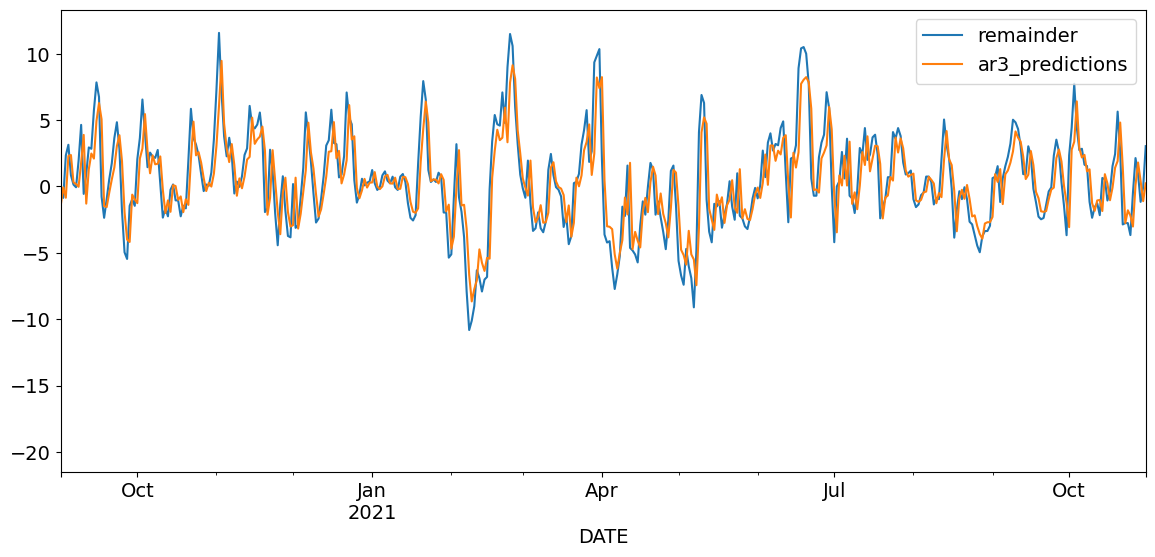

In [16]:
# Plot the prediction for pure-AR-model

df2=df_train.loc['2020-09-01':]
df2['remainder'].plot()
plt.plot(ar3_model.predict(), label='ar3_predictions') # insample prediction
plt.legend()
plt.show()

In [17]:
# Employ AIC, BIC to compare two different models
print(round(ar3_model.bic,2), round(ar3_model.aic,2))

240076.53 240032.12


In [18]:
# calculate rmse on training data for absolute error.
rmse_no_seasonality = np.sqrt(mean_squared_error(df_train['remainder'], ar3_model.predict().dropna()))
rmse_no_seasonality

ValueError: Found input variables with inconsistent numbers of samples: [53210, 53207]

#### ARIMA (for optimized p,q,d=0)

In [ ]:
# fit and ARIMA (3,0,2) model (p,d,q)

arima302_model = ARIMA(df_train['remainder'], order=(3,0,2)).fit()

In [ ]:
df2=df_train.loc['2020-09-01':]
df2['remainder'].plot()
plt.plot(arima302_model.predict(), label='ARIMA_predictions') # insample prediction
plt.legend()
plt.show()

In [ ]:
print(round(arima302_model.bic,2), round(arima302_model.aic,2))

#### Alternative model: LR for remainder

In [ ]:
# Assign X and y
X = df_train[['lag_1']]
y = df_train['remainder']

In [ ]:
# Create and fit the model
m_AR = LinearRegression()
m_AR.fit(X,y)

In [ ]:
# Create predictions
df_train['pred_ar1'] = m_AR.predict(X)
df_train.head(1)

In [ ]:
df2 = df_train.loc['1876-01-02':'1877-01-02']
plot_graph(df2[['remainder','pred_ar1']])

#### But which lag should we choose for best model? To understanding it we should check p

#### Inspect correlation between train data and lags 

In [ ]:
lags_order = ar_select_order(df_train['remainder'], maxlag=5)

In [ ]:
lags_order.ar_lags

In [ ]:
lags_order.bic